# Binding Energy between proton and neutron in the Deuteron nucleus

In the current stage of quantum computing, NISQ era, we have some limitations about the problems we can solve, because the quantum processors that we have available do not have error correcting code implemented and they still have a significant amount of noise. Thus, the results produced by these systems do not have a high level of confidence and precision. However, there are some problems which demand a few qubits to be solved, like the computation of the binding energy between proton and neutron in the Deuteron nucleus [1]. This problem is an example of a scenario where we can achieve good results despite the challenges mentioned earlier.


## Step 1: Importing the packages that we need to tackle the problem

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from qiskit import Aer
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.opflow import I, X, Y, Z, StateFn, CircuitSampler, PauliExpectation
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import COBYLA, SLSQP
from qiskit_nature.operators.second_quantization import FermionicOp
from qiskit_nature.mappers.second_quantization import JordanWignerMapper
from qiskit_nature.converters.second_quantization import QubitConverter

## Step 2: Defining some functions that we will use

Before we start the definition of the Deuteron Hamiltonian, we need to define a function that performs the behavior of a mathematical function, the Kronecker delta function, which is defined as follows:

$\delta_{nm} = \bigg\{\begin{array}{c}0, \ \textrm{if} \ n \neq m \\1, \ \textrm{if } \ n = m.\end{array}$.

This function appears in the Deuteron Hamiltonian definition given in [1]. Below we have a piece of code that defines the Kronecker delta function.

In [2]:
def kronecker_delta_function(n: int, m: int) -> int:
    """An implementation of the Kronecker delta function.

    Args:
        n (int): The first integer argument.
        m (int): The second integer argument.

    Returns:
        Returns 1 if n = m, else returns 0.
    """
    return int(n == m)

In [1] we can find the following expression for the Deuteron Hamiltonian
$H_N = \sum_{n,m=0}^{N-1}\langle m|(T+V)|n\rangle a_{m}^\dagger a_n$,
where $|n\rangle$ and $|m\rangle$ represent quantum states in the harmonic oscillator basis. With that in mind, the operators $a_n^\dagger$ and $a_n$ represent the operators of creation and annihilation.

To create the code that defines $H_N$, we need the matrix elements of the kinetic and potential energy. These expressions we can find in [1] written in the following way
$\langle m|T|n\rangle = \frac{\hbar\omega}{2}\left[\left(2n+\frac{3}{2}\right)\delta_{nm}-\sqrt{n(n+\frac{1}{2})}\delta_{nm+1}-\sqrt{(n+1)(n+\frac{3}{2})}\delta_{nm-1}\right],$
$\langle m|V|n\rangle = V_0\delta_{n0}\delta_{nm}.$

Where $V_0 = -5.68658111 \ \textrm{MeV}$ and $\hbar\omega = 7 \ \textrm{MeV}$. However, the Hamiltonian written in this way cannot be processed directly in a quantum computer, because a quantum computer manipulates qubits through gates based on Pauli matrices. Thus, we need to convert the operators of creation and annihilation in Pauli operators, to do that we need to make use of the Jordan-Wigner transformation

$a_n^\dagger \ \rightarrow \ \frac{1}{2}\left[\prod_{j=0}^{n-1}-Z_j\right](X_n-iY_n),$

$a_n \ \rightarrow \ \frac{1}{2}\left[\prod_{j=0}^{n-1}-Z_j\right](X_n+iY_n).$

Fortunately, in Qiskit Nature we have tools to define fermionic operators and to convert this kind of operators into Pauli operators through the Jordan-Wigner transformation. Initially, we have to define an empty variable called hamiltonian, using the `zero()` method of the object `FermionicOp`. After this, we use a for loop to create the string label that is used to create the `FermionicOp` that we will use in matrix elements of kinetic and potential energies. Then, we use each matrix element to update our initial hamiltonian variable. At the end of the for loop, we have in hands a Hamiltonian in terms of the creation and annihilation operators, so we need to use `JordanWignerMapper()` and the `QubitConverter()` to complete the task of obtain the Deuteron Hamiltonian in terms of Pauli operators. In order to obtain more information about the Qiskit Nature tools, we recommend a reading of the Qiskit documentation [3]. 

In [3]:
def create_deuteron_hamiltonian(N: int):
    """Creates a version of the Deuteron Hamiltonian in terms of operators
    compatible with qubits.

        Args:
            N (int): An integer number that represents the dimension of the
            basis.

        Returns:
            A Hamiltonian converted to qubits that represents the Deuteron.
    """
    if type(N) == int:
        hamiltonian = FermionicOp.zero(N)

        for i in range(N):
            for j in range(N):

                label = "+_{} -_{}".format(str(i), str(j))
                hamiltonian += (
                    3.5
                    * (
                        (2 * j + 3 / 2) * kronecker_delta_function(i, j)
                        - np.sqrt(j * (j + (1 / 2))) * kronecker_delta_function(i + 1, j)
                        - np.sqrt((j + 1) * (j + (3 / 2)) * kronecker_delta_function(i - 1, j))
                    )
                    * FermionicOp(label, display_format="sparse")
                )
                hamiltonian += (
                    -5.68658111
                    * kronecker_delta_function(0, j)
                    * kronecker_delta_function(i, j)
                    * FermionicOp(label, display_format="sparse")
                )

        mapper = JordanWignerMapper()
        qubit_converter = QubitConverter(mapper=mapper)
        qubit_hamiltonian = qubit_converter.convert(hamiltonian)

        return qubit_hamiltonian
    else:
        raise ValueError(
            "The function expects an integer number ('int') as input, but was given a {} type.".format(
                type(N)
            )
        )

Now, we have an idea of how to use some of Qiskit Nature tools to build a Hamiltonian in terms of Pauli operators. However, this is not the end, we need to construct an ansatz through a parameterized quantum circuit and use it in the VQE to compute the minimum eigenvalue of the Deuteron Hamiltonian (binding energy).

In [4]:
def callback(eval_count, parameters, mean, std):
    # Overwrites the same line when printing
    display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)

In Dirac notation (bra-ket), the definition of the expectation value of an observable $\hat{O}$ is equal to [4,5]:

$\langle \hat{O} \rangle_\psi = \langle \psi(\vec{\theta})|\hat{O}|\psi(\vec{\theta}) \rangle$.

The code below defines a function that calculates the expectation values of observables, given a parameterized quantum circuit and a list with some values for these parameters (angles). To build the `calculate_observables_exp_values` we use some tools of Qiskit Opflow.

In [5]:
def calculate_observables_exp_values(
    quantum_circuit: QuantumCircuit, observables: list, angles: list
) -> list:
    """Calculate the expectation value of an observable given the quantum
    circuit that represents the wavefunction and a list of parameters.

        Args:
            quantum_circuit (QuantumCircuit): A parameterized quantum circuit
            that represents the wavefunction of the system.

            observables (list): A list containing the observables that we want
            to know the expectation values.

            angles (list): A list with the values that will be used in the
            'bind_parameters' method.

        Returns:
            list_exp_values (list): A list containing the expectation values
            of the observables given as input.
    """
    list_exp_values = []
    for observable in observables:
        exp_values = []
        for angle in angles:
            observable_op = observable
            observable_ad = StateFn(observable_op).adjoint()
            observable_exp = observable_ad @ StateFn(quantum_circuit)
            diagonalized_meas_op = PauliExpectation().convert(observable_exp)
            sampler = CircuitSampler(backend=Aer.get_backend("qasm_simulator"))
            sampler.quantum_instance.run_config.shots = 8192
            observable_expectations = diagonalized_meas_op.bind_parameters({theta: angle})
            sampled_exp_op = sampler.convert(observable_expectations)
            sampled_exp_ev = sampled_exp_op.eval()

            exp_values.append(np.real(sampled_exp_ev))
        list_exp_values.append(exp_values)

    return list_exp_values

## Step 3: Using Qiskit tools to calculate the binding energy between proton and neutron in Deuteron nucleus

In the previous step, we have defined the functions that will be useful to us in the task of calculating the binding energy between proton and neutron in the Deuteron nucleus. Thus, now it is time to start the process of solving the problem with the tools we built.

First, we need to initialize some important variables that we will use a lot during this tutorial. These variables can be found in the code cell below.

In [6]:
statevec_sim = Aer.get_backend("statevector_simulator")
qasm_sim = Aer.get_backend("qasm_simulator")
shots = 8192

Now it is time to create the list that will store the Hamiltonians $H_1$, $H_2$, $H_3$ and $H_4$. To do this, we can do a list comprehension with the function create_deuteron_hamiltonian that we defined above. 

In [7]:
deuteron_hamiltonians = [create_deuteron_hamiltonian(i) for i in range(1, 5)]

In reference [1], we can find the expressions Deuteron Hamiltonian for N = 1, 2 and 3 given below.

$H_1 = 0.218291(Z_0-I_0)$

$H_2 = 5.906709I_1\otimes I_0 + 0.218291I_1\otimes Z_0 - 6.215Z_1\otimes I_0 - 2.143304(X_1\otimes X_0 + Y_1 \otimes Y_0)$

$H_3 = I_2\otimes H_2 + 9.625(I_2\otimes I_1\otimes I_0 - Z_2\otimes I_1\otimes I_0) - 3.913119(X_2\otimes X_1\otimes I_0 + Y_2\otimes Y_1\otimes I_0)$

If we want to know if our create_deuteron_hamiltonian gives us the right result, we have to compare with the expressions presented above. For this purpose, we printed the Hamiltonians generated by the function create_deuteron_hamiltonian in the cell below, so this way we can check if we have the right expressions. 

In [8]:
i = 1
for hamiltonian in deuteron_hamiltonians:
    print("Deuteron Hamiltonian: H_{}".format(i))
    print(hamiltonian)
    print("\n")
    i += 1

Deuteron Hamiltonian: H_1
-0.21829055499999983 * I
+ 0.21829055499999983 * Z


Deuteron Hamiltonian: H_2
5.906709445000001 * II
+ 0.21829055499999983 * IZ
- 2.1433035249352805 * YY
- 2.1433035249352805 * XX
- 6.125 * ZI


Deuteron Hamiltonian: H_3
15.531709445 * III
+ 0.21829055499999983 * IIZ
- 2.1433035249352805 * IYY
- 2.1433035249352805 * IXX
- 6.125 * IZI
- 3.913118960624632 * YYI
- 3.913118960624632 * XXI
- 9.625 * ZII


Deuteron Hamiltonian: H_4
28.656709445 * IIII
+ 0.21829055499999983 * IIIZ
- 2.1433035249352805 * IIYY
- 2.1433035249352805 * IIXX
- 6.125 * IIZI
- 3.913118960624632 * IYYI
- 3.913118960624632 * IXXI
- 9.625 * IZII
- 5.670648111106878 * YYII
- 5.670648111106878 * XXII
- 13.125 * ZIII




By inspection, we can see that our function is giving us the right result for $H_1$, $H_2$ and $H_3$. However, we don't have an expression for $H_4$ in [1], but it is possible to say, by induction, that the result must be correct once the previous results matched with the expressions given in [1].

In [1], the authors worked with ansatz represented by quantum circuits with low depth, because they wanted to compute things in a real quantum device. Those quantum circuits can be found in [1]. As we already discussed in the beginning of this tutorial, the current quantum hardware available has to work with quantum circuits with low depth to achieve good results, once they still have a significant amount of noise and don't have quantum error correction implemented.

We need to define two parameters to build the circuits presented in [1], $\theta$ (theta) and $\eta$ (eta), we can do it using Parameter() as written in the cell code below.

In [9]:
theta = Parameter(r"$\theta$")
eta = Parameter(r"$\eta$")

Using the parameters defined above and following the instructions to build the circuits presented in [1], we obtain the following circuits:

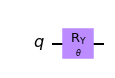

In [10]:
wavefunction = QuantumCircuit(1)
wavefunction.ry(theta, 0)
wavefunction.draw("mpl")

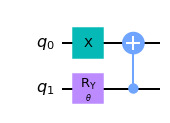

In [11]:
wavefunction2 = QuantumCircuit(2)
wavefunction2.x(0)
wavefunction2.ry(theta, 1)
wavefunction2.cx(1, 0)
wavefunction2.draw("mpl")

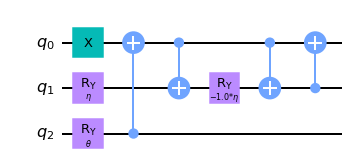

In [12]:
wavefunction3 = QuantumCircuit(3)
wavefunction3.x(0)
wavefunction3.ry(eta, 1)
wavefunction3.ry(theta, 2)
wavefunction3.cx(2, 0)
wavefunction3.cx(0, 1)
wavefunction3.ry(-eta, 1)
wavefunction3.cx(0, 1)
wavefunction3.cx(1, 0)
wavefunction3.draw("mpl")

Now, we can store these circuits in the ansatz list for the organization of the tests.

In [13]:
ansatz = [wavefunction, wavefunction2, wavefunction3]

The complexity of this problem, allow us to use numpy functions (classical methods) to obtain the binding energy for $H_1$, $H_2$, $H_3$ and $H_4$ through the process of finding the lowest eigenvalue of the Hamiltonians matrices. This task is done in the for loop of the code cell below. 

In [14]:
reference_values = []
i = 0
print("Exact binding energies calculated through numpy.linalg.eigh \n")
for hamiltonian in deuteron_hamiltonians:
    eigenvalues, eigenstates = np.linalg.eigh(hamiltonian.to_matrix())
    reference_values.append(eigenvalues[0])
    i = i + 1
    print("Exact binding energy for H_{}: {}".format(i, eigenvalues[0]))

Exact binding energies calculated through numpy.linalg.eigh 

Exact binding energy for H_1: -0.43658110999999966
Exact binding energy for H_2: -1.7491598763215301
Exact binding energy for H_3: -2.045670898406441
Exact binding energy for H_4: -2.143981030799862


The results obtained above will be used as our reference values, thus we can use them to see if the statevector and the qasm simulators give us good results. In the code cell below we ran VQE for each pair of ansatz and Hamiltonian, using the statevector simulator and as optimizer the SLSQP. 

In [15]:
print(
    "Results using statevector simulator for H_1, H_2 and H_3 with the ansatz given in the reference paper \n"
)
for i in range(3):
    seed = 42
    algorithm_globals.random_seed = seed
    qi_sv = QuantumInstance(backend=statevec_sim, seed_simulator=seed, seed_transpiler=seed)
    vqe = VQE(
                ansatz=ansatz[i], optimizer=SLSQP(), quantum_instance=qi_sv
            )
    vqe_result = vqe.compute_minimum_eigenvalue(deuteron_hamiltonians[i])
    binding_energy = vqe_result.optimal_value
    print("Binding energy for H_{}: {} MeV".format(i + 1, binding_energy))

Results using statevector simulator for H_1, H_2 and H_3 with the ansatz given in the reference paper 

Binding energy for H_1: -0.4365811096105192 MeV
Binding energy for H_2: -1.7491595316569941 MeV
Binding energy for H_3: -2.0456708982584066 MeV


We did the same thing done above, but with the qasm simulator and with include_custom set as True in VQE. This VQE mode makes qasm simulator behaves like a statevector simulator, because there is no shot noise in this method, but run faster than statevector simulator due difference of implementation.  

In [16]:
print(
    "Results using VQE with include_custom=True for H_1, H_2 and H_3 with the ansatz given in the reference paper \n"
)
for i in range(3):
    seed = 42
    algorithm_globals.random_seed = seed
    qi_qasm = QuantumInstance(
        backend=qasm_sim, shots=shots, seed_simulator=seed, seed_transpiler=seed
    )
    vqe = VQE(
                ansatz=ansatz[i],
                optimizer=SLSQP(),
                quantum_instance=qi_qasm,
                include_custom=True,
            )
    vqe_result = vqe.compute_minimum_eigenvalue(deuteron_hamiltonians[i])
    binding_energy = vqe_result.optimal_value
    print("Binding energy for H_{}:".format(i + 1), binding_energy, "MeV")

Results using VQE with include_custom=True for H_1, H_2 and H_3 with the ansatz given in the reference paper 

Binding energy for H_1: -0.43658110960974106 MeV
Binding energy for H_2: -1.7491595316396333 MeV
Binding energy for H_3: -2.045670898259063 MeV


In both scenarios presented above, we can see that our results are in agreement with the reference values obtained by classical methods. We also tested some different options of optimizers provided in Qiskit, because we wanted to know which one behaves better in a qasm simulator with a shot noise scenario. To do this, we make use of the callback option in VQE to allow us to store the list of counts and values, with these information it is possible to make a plot to see if the optimizer converges to the value of reference and if it converges, how fast it does it. However, in code cell below, we are working only with COBYLA for the sake of simplicity and time to run.

In [18]:
plots = []

for i in range(3):
    
    counts = []
    values = []
    params = []
    deviation = []
    seed = 42
    algorithm_globals.random_seed = seed
    qi_qasm = QuantumInstance(
        backend=qasm_sim, shots=shots, seed_simulator=seed, seed_transpiler=seed
    )
    vqe = VQE(
                ansatz=ansatz[i],
                optimizer=COBYLA(),
                quantum_instance=qi_qasm,
                callback=callback
            )
    vqe_result = vqe.compute_minimum_eigenvalue(deuteron_hamiltonians[i])
    plots.append([counts, values])

'Evaluation: 45, Energy: -2.0560597369519478, Std: 0.08776774665206473'

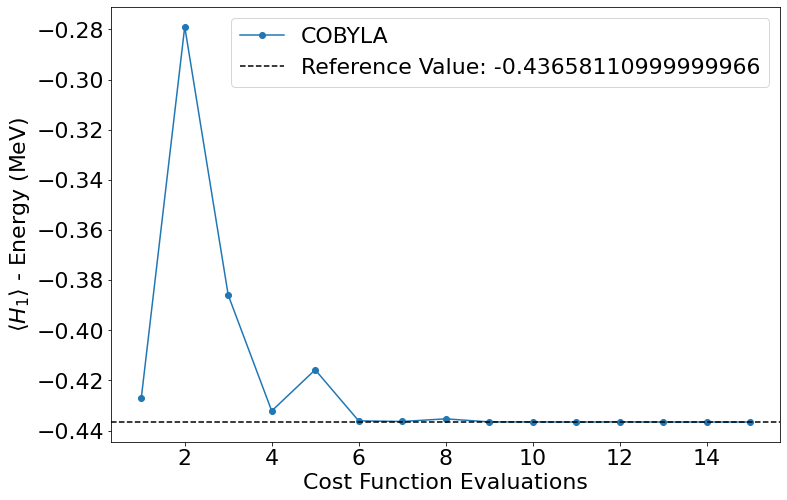

In [19]:
plt.figure(figsize=(12, 8))
plt.rcParams.update({"font.size": 22})
plt.plot(plots[0][0], plots[0][1], "o-", label="COBYLA")
plt.axhline(
    y=reference_values[0],
    color="k",
    linestyle="--",
    label="Reference Value: {}".format(reference_values[0]),
)
plt.legend()
plt.xlabel("Cost Function Evaluations")
plt.ylabel(r"$\langle H_1 \rangle $ - Energy (MeV)")
plt.show()

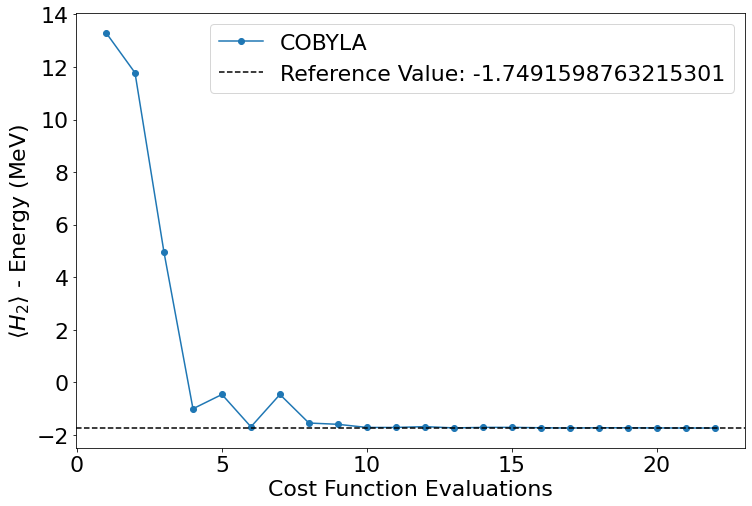

In [20]:
plt.figure(figsize=(12, 8))
plt.rcParams.update({"font.size": 22})
plt.plot(plots[1][0], plots[1][1], "o-", label="COBYLA")
plt.axhline(
    y=reference_values[1],
    color="k",
    linestyle="--",
    label="Reference Value: {}".format(reference_values[1]),
)
plt.legend()
plt.xlabel("Cost Function Evaluations")
plt.ylabel(r"$\langle H_2 \rangle $ - Energy (MeV)")
plt.show()

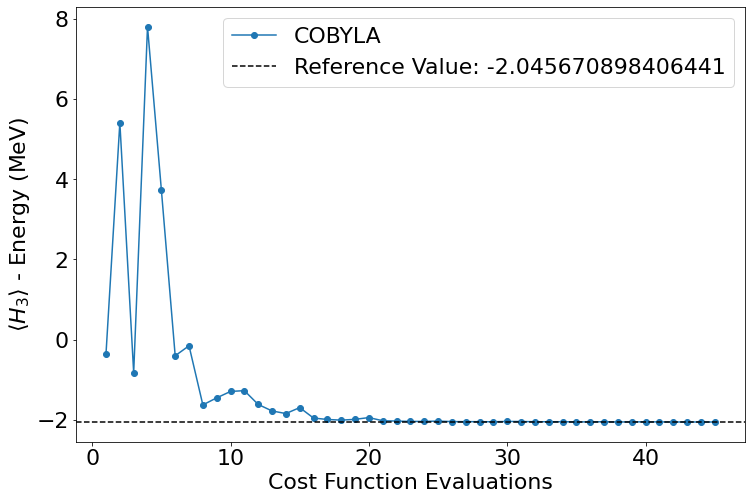

In [21]:
plt.figure(figsize=(12, 8))
plt.rcParams.update({"font.size": 22})
plt.plot(plots[2][0], plots[2][1], "o-", label="COBYLA")
plt.axhline(
    y=reference_values[2],
    color="k",
    linestyle="--",
    label="Reference Value: {}".format(reference_values[2]),
)
plt.legend()
plt.xlabel("Cost Function Evaluations")
plt.ylabel(r"$\langle H_3 \rangle $ - Energy (MeV)")
plt.show()

Note that with the quantum circuits given in [1], we can't test whether we can reach the reference value for $H_4$, because we don't have an ansatz for this Hamiltonian. Fortunately, that is not the end for our experiments, because Qiskit provides some functions that create ansatz for us. For our purposes, we decided to use the TwoLocal function to build our new ansatz. In the code cell below we used a for loop to create a list with the TwoLocal ansatz for each Hamiltonian. 

In [22]:
twolocal = []
for i in range(1, 5):
    ansatz_tl = TwoLocal(
        deuteron_hamiltonians[i - 1].num_qubits,
        ["rz", "ry"],
        "cx",
        entanglement="full",
        reps=i,
        initial_state=None,
    )
    twolocal.append(ansatz_tl)

Now we can check if with this new type of ansatz, we can reach the reference values obtained through classical methods. To do this verification, we have to repeat the experiments done previously, but now using the ansatz defined through the usage of TwoLocal function.

In [23]:
print("Results using statevector simulator for H_1, H_2, H_3 and H_4 with TwoLocal ansatz \n")
for i in range(4):
    seed = 42
    algorithm_globals.random_seed = seed
    qi_sv = QuantumInstance(backend=statevec_sim, seed_simulator=seed, seed_transpiler=seed)
    vqe = VQE(
                ansatz=twolocal[i], optimizer=SLSQP(), quantum_instance=qi_sv
            )
    vqe_result = vqe.compute_minimum_eigenvalue(deuteron_hamiltonians[i])
    binding_energy = vqe_result.optimal_value
    print("Binding energy for H_{}:".format(i + 1), binding_energy, "MeV")

Results using statevector simulator for H_1, H_2, H_3 and H_4 with TwoLocal ansatz 

Binding energy for H_1: -0.43658065603907537 MeV
Binding energy for H_2: -1.74915985600304 MeV
Binding energy for H_3: -2.04567053646057 MeV
Binding energy for H_4: -2.143976696246006 MeV


In [24]:
print(
    "Results using VQE with include_custom=True for H_1, H_2, H_3 and H_4 with TwoLocal ansatz \n"
)
for i in range(4):
    seed = 42
    algorithm_globals.random_seed = seed
    qi_qasm = QuantumInstance(
        backend=qasm_sim, shots=shots, seed_simulator=seed, seed_transpiler=seed
    )
    vqe = VQE(
                ansatz=twolocal[i], optimizer=SLSQP(), quantum_instance=qi_qasm, include_custom=True
            )
    vqe_result = vqe.compute_minimum_eigenvalue(deuteron_hamiltonians[i])
    binding_energy = vqe_result.optimal_value
    print("Binding energy for H_{}:".format(i + 1), binding_energy, "MeV")

Results using VQE with include_custom=True for H_1, H_2, H_3 and H_4 with TwoLocal ansatz 

Binding energy for H_1: -0.4365806560100841 MeV
Binding energy for H_2: -1.7491598388871887 MeV
Binding energy for H_3: -2.045670536818389 MeV
Binding energy for H_4: -2.143976324261814 MeV


In [25]:
plots_ic = []
for i in range(4):
    
    counts = []
    values = []
    params = []
    deviation = []
    seed = 42
    algorithm_globals.random_seed = seed
    qi_qasm = QuantumInstance(
        backend=qasm_sim, shots=shots, seed_simulator=seed, seed_transpiler=seed
    )
    vqe = VQE(
                ansatz=twolocal[i], optimizer=SLSQP(), quantum_instance=qi_qasm, callback=callback, include_custom=True
            )
    vqe_result = vqe.compute_minimum_eigenvalue(deuteron_hamiltonians[i])
    plots_ic.append([counts, values])

'Evaluation: 3858, Energy: -2.143976324267731, Std: 0.0'

Using the four ansatz defined through TwoLocal function, we obtained the following results:

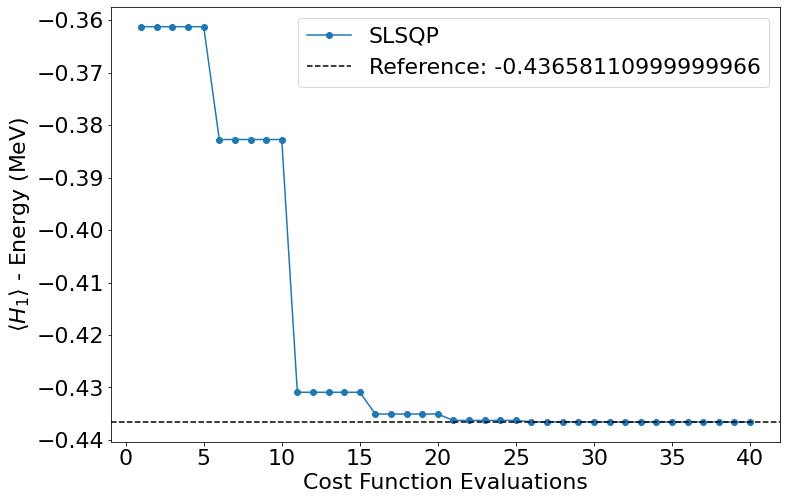

In [26]:
plt.figure(figsize=(12, 8))
plt.rcParams.update({"font.size": 22})
plt.plot(plots_ic[0][0], plots_ic[0][1], "o-", label="SLSQP")
plt.axhline(
    y=reference_values[0],
    color="k",
    linestyle="--",
    label="Reference: {}".format(reference_values[0]),
)
plt.legend()
plt.xlabel("Cost Function Evaluations")
plt.ylabel(r"$\langle H_1 \rangle $ - Energy (MeV)")
plt.show()

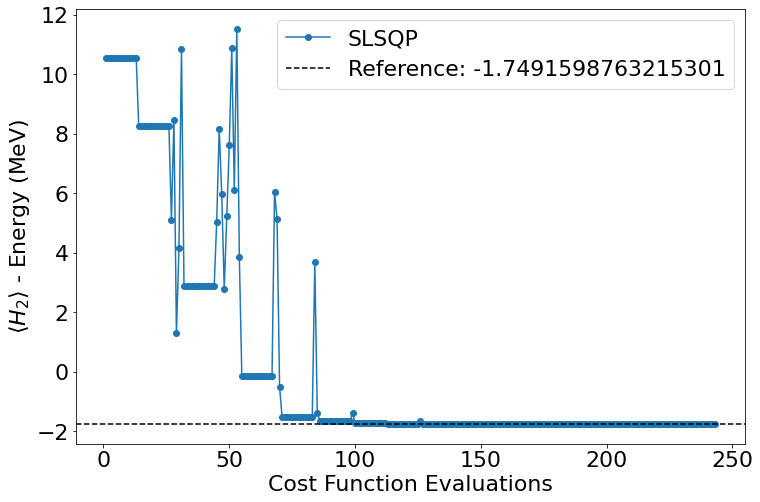

In [27]:
plt.figure(figsize=(12, 8))
plt.rcParams.update({"font.size": 22})
plt.plot(plots_ic[1][0], plots_ic[1][1], "o-", label="SLSQP")
plt.axhline(
    y=reference_values[1],
    color="k",
    linestyle="--",
    label="Reference: {}".format(reference_values[1]),
)
plt.legend()
plt.xlabel("Cost Function Evaluations")
plt.ylabel(r"$\langle H_2 \rangle $ - Energy (MeV)")
plt.show()

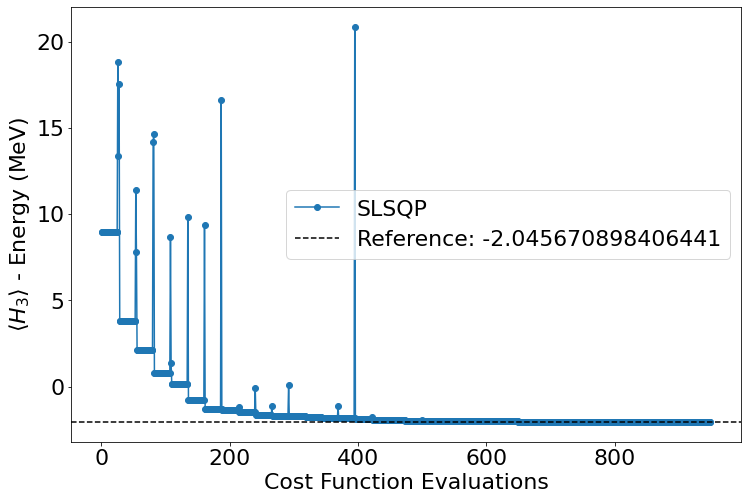

In [28]:
plt.figure(figsize=(12, 8))
plt.rcParams.update({"font.size": 22})
plt.plot(plots_ic[2][0], plots_ic[2][1], "o-", label="SLSQP")
plt.axhline(
    y=reference_values[2],
    color="k",
    linestyle="--",
    label="Reference: {}".format(reference_values[2]),
)
plt.legend()
plt.xlabel("Cost Function Evaluations")
plt.ylabel(r"$\langle H_3 \rangle $ - Energy (MeV)")
plt.show()

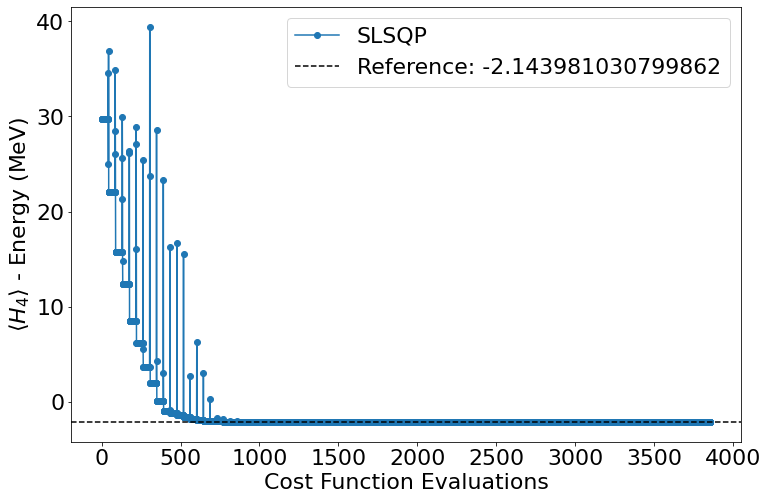

In [29]:
plt.figure(figsize=(12, 8))
plt.rcParams.update({"font.size": 22})
plt.plot(plots_ic[3][0], plots_ic[3][1], "o-", label="SLSQP")
plt.axhline(
    y=reference_values[3],
    color="k",
    linestyle="--",
    label="Reference: {}".format(reference_values[3]),
)
plt.legend()
plt.xlabel("Cost Function Evaluations")
plt.ylabel(r"$\langle H_4 \rangle $ - Energy (MeV)")
plt.show()

## Step 4: Calculating the observables expectation values

One of our goals in this project was to show that it is possible to calculate expectation values of some observables of interest and show how they behave when we vary a parameter in the ansatz circuit. In our case, the observables of interest were $I_1\otimes Z_0$, $Z_1\otimes I_0$, $X_1\otimes X_0$, $Y_1\otimes Y_0$ and $H_2$, then we investigate their behavior when the parameter $\theta$ was varying inside the interval $[-\pi,\pi]$.

In [30]:
angles = list(np.linspace(-np.pi, np.pi, 100))
observables = [I ^ Z, Z ^ I, X ^ X, Y ^ Y, deuteron_hamiltonians[1]]

h2_observables_exp_values = calculate_observables_exp_values(wavefunction2, observables, angles)

Using the function h2_observables_exp_values (we defined it in the Step 2), we got the plots presented below. They showed us that we were able to reproduce the results of [1].

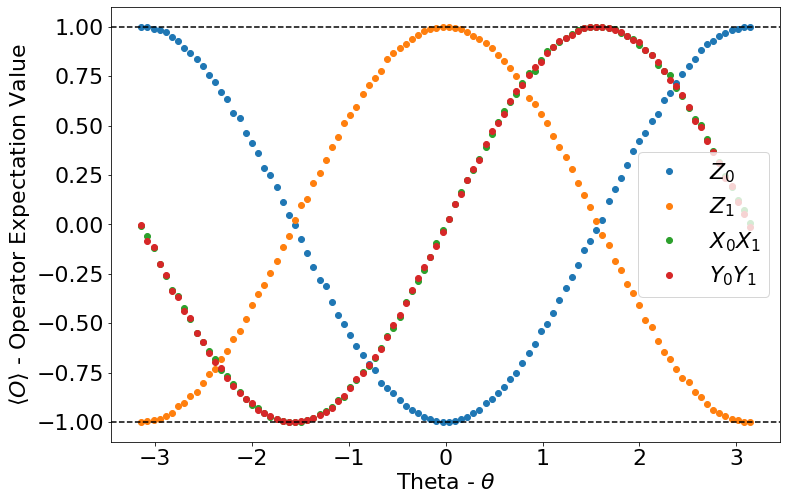

In [31]:
plt.figure(figsize=(12, 8))
plt.rcParams.update({"font.size": 22})
plt.plot(angles, h2_observables_exp_values[0], "o", label=r"$Z_0$")
plt.plot(angles, h2_observables_exp_values[1], "o", label=r"$Z_1$")
plt.plot(angles, h2_observables_exp_values[2], "o", label=r"$X_0X_1$")
plt.plot(angles, h2_observables_exp_values[3], "o", label=r"$Y_0Y_1$")
plt.axhline(
    y=1,
    color="k",
    linestyle="--",
)
plt.axhline(y=-1, color="k", linestyle="--")
plt.legend()
plt.xlabel(r"Theta - $\theta$")
plt.ylabel(r"$\langle O \rangle $ - Operator Expectation Value")
plt.show()

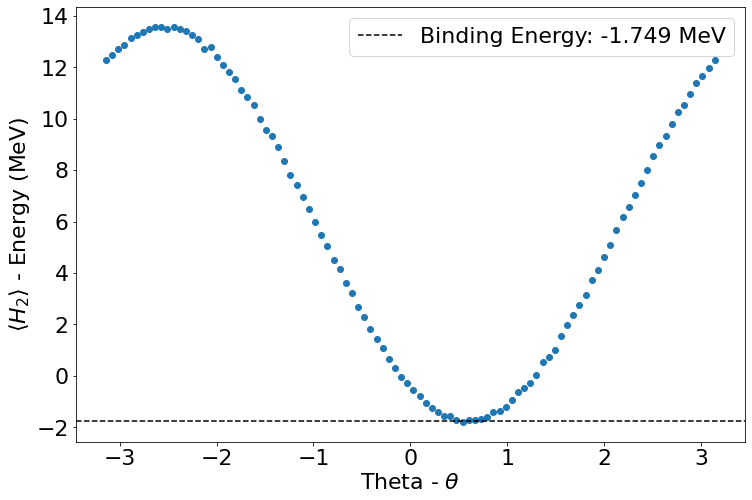

In [32]:
plt.figure(figsize=(12, 8))
plt.rcParams.update({"font.size": 22})
plt.plot(angles, h2_observables_exp_values[4], "o")
plt.axhline(
    y=reference_values[1],
    color="k",
    linestyle="--",
    label="Binding Energy: {} MeV".format(np.round(reference_values[1], 3)),
)
plt.legend()
plt.xlabel(r"Theta - $\theta$")
plt.ylabel(r"$\langle H_2 \rangle $ - Energy (MeV)")
plt.show()

# Acknowledgement

I would like to thanks Steve Wood, Soham Pal and Siddhartha Morales for our conversations in our meetings during the Qiskit Advocate Mentorship Program 2021 - Fall. 

# References

[1] Dumitrescu, Eugene F., et al. "Cloud quantum computing of an atomic nucleus." Physical review letters 120.21 (2018): 210501. Arxiv version: https://arxiv.org/pdf/1801.03897.pdf

[2] Deuterium Wikipedia article. https://en.wikipedia.org/wiki/Deuterium

[3] Qiskit Documentation. https://qiskit.org/documentation/

[4] Feynman, R. P., Robert B. Leighton, and Matthew Sands. "The Feynman Lectures on Physics, Volume III: Quantum Mechanics, vol. 3." (2010). https://www.feynmanlectures.caltech.edu/III_toc.html

[5] Expectation value (quantum mechanics) Wikipedia article. https://en.wikipedia.org/wiki/Expectation_value_(quantum_mechanics)

In [1]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright